In [89]:
import os
import re
from collections import Counter
import pandas as pd
from collections import defaultdict

In [90]:
def extract_participants_info(filepath):
    participants = {}
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                if line.startswith('@Participants:'):
                    line = line.strip().replace('@Participants:\t', '')
                    entries = line.split(', ')
                    for entry in entries:
                        parts = entry.strip().split(' ')
                        if len(parts) >= 3:
                            label, name = parts[0], parts[1]
                            role = ' '.join(parts[2:])
                            participants[label] = (name, role)
                    break  # only one @Participants line expected
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
    return participants

def collect_speaker_metadata(root_dir):
    label_data = defaultdict(set)

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.cha'):
                filepath = os.path.join(subdir, file)
                participants = extract_participants_info(filepath)

                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        for line in f:
                            if line.startswith('*'):
                                match = re.match(r'\*(\w+):', line)
                                if match:
                                    label = match.group(1)
                                    name, role = participants.get(label, ('Unknown', 'Unknown'))
                                    label_data[label].add((name, role))
                except Exception as e:
                    print(f"Error reading {filepath}: {e}")

    # Flatten to list of dicts
    rows = []
    for label, entries in label_data.items():
        for name, role in entries:
            rows.append({'Label': label, 'Name': name, 'Role': role})

    return pd.DataFrame(rows)


In [ ]:
%%sql


In [91]:
df = collect_speaker_metadata("Mandarin")
df.sort_values(by='Label').drop_duplicates().reset_index(drop=True)
df

,Label,Name,Role
0,MOT,阿蘋,Mother
1,MOT,阿秀,Mother
2,MOT,阿妙,Mother
3,MOT,魏魏,Mother
4,MOT,黃佳佳,Mother
...,...,...,...
1655,SHO,吳阿秀Shou,Target_Child
1656,FRE,Fred,Investigator
1657,UNI,Unknown,Unknown
1658,LIA,Unknown,Unknown


In [92]:
def collect_speaker_metadata(root_dir):
    label_data = defaultdict(lambda: {'Names': set(), 'Roles': set()})

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.cha'):
                filepath = os.path.join(subdir, file)

                participants = {}
                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        if line.startswith('@Participants:'):
                            line = line.strip().replace('@Participants:\t', '')
                            for entry in line.split(', '):
                                parts = entry.split(' ')
                                if len(parts) >= 3:
                                    label = parts[0]
                                    name = parts[1]
                                    role = ' '.join(parts[2:])
                                    participants[label] = (name, role)
                            break

                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        if line.startswith('*'):
                            match = re.match(r'\*(\w+):', line)
                            if match:
                                label = match.group(1)
                                name, role = participants.get(label, ('Unknown', 'Unknown'))
                                label_data[label]['Names'].add(name)
                                label_data[label]['Roles'].add(role)

    rows = []
    for label, info in label_data.items():
        rows.append({
            'Label': label,
            'Names': sorted(info['Names']),
            'Roles': sorted(info['Roles'])
        })

    return pd.DataFrame(rows)

In [93]:
df = collect_speaker_metadata("Mandarin")
df

,Label,Names,Roles
0,MOT,"[Mother, Unknown, 媽媽, 櫻櫻, 母親, 阿卿, 阿君, 阿如, 阿妙, ...","[, ,, Adult, Adult , Mother, Unknown]"
1,CHI,"[Abudula, Adibai, Aerfati, Ailixxxiade, Ailiya...","[, ,, Child, Target_Child, Target_Child , Targ..."
2,EXP,"[Investigator, Unknown]","[, Unknown]"
3,FAT,"[Father, Unknown, 父親, 爸爸]","[, ,, Adult, Adult , Unknown]"
4,INV,"[Investigator, Unknown, Wang, XiaLing]","[, ,, Investigator, Investigator , Unknown]"
...,...,...,...
65,SHO,"[Unknown, 吳阿秀Shou]","[Target_Child, Unknown]"
66,FRE,[Fred],[Investigator]
67,UNI,[Unknown],[Unknown]
68,LIA,[Unknown],[Unknown]


In [94]:
from collections import defaultdict

def collect_speaker_metadata(root_dir):
    label_data = defaultdict(lambda: {'Names': set(), 'Roles': set(), 'Files': set(), 'Ages': set()})

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.cha'):
                filepath = os.path.join(subdir, file)

                participants = {}
                ages = {}
                with open(filepath, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                for line in lines:
                    if line.startswith('@Participants:'):
                        line = line.strip().replace('@Participants:\t', '')
                        for entry in line.split(', '):
                            parts = entry.split(' ')
                            if len(parts) >= 3:
                                label = parts[0]
                                name = parts[1]
                                role = ' '.join(parts[2:])
                                participants[label] = (name, role)
                    elif line.startswith('@ID:'):
                        parts = line.strip().split('|')
                        if len(parts) >= 5:
                            label = parts[2]
                            age = parts[3].strip('.')
                            if age:
                                ages[label] = age

                for line in lines:
                    if line.startswith('*'):
                        match = re.match(r'\*(\w+):', line)
                        if match:
                            label = match.group(1)
                            name, role = participants.get(label, ('Unknown', 'Unknown'))
                            age = ages.get(label, None)
                            label_data[label]['Names'].add(name)
                            label_data[label]['Roles'].add(role)
                            label_data[label]['Files'].add(filepath)
                            if age:
                                label_data[label]['Ages'].add(age)

    rows = []
    for label, info in label_data.items():
        rows.append({
            'Label': label,
            'Names': sorted(info['Names']),
            'Roles': sorted(info['Roles']),
            'Files': sorted(info['Files']),
            'Ages': sorted(info['Ages']) if info['Ages'] else None
        })

    return pd.DataFrame(rows)


In [95]:
df = collect_speaker_metadata("Mandarin")
df

,Label,Names,Roles,Files,Ages
0,MOT,"[Mother, Unknown, 媽媽, 櫻櫻, 母親, 阿卿, 阿君, 阿如, 阿妙, ...","[, ,, Adult, Adult , Mother, Unknown]","[Mandarin/Beijing/bb/011013.cha, Mandarin/Beij...","[1;11.05, 27;00, 28;00, 29;00, 30;00, 31;00, 3..."
1,CHI,"[Abudula, Adibai, Aerfati, Ailixxxiade, Ailiya...","[, ,, Child, Target_Child, Target_Child , Targ...","[Mandarin/AcadLang/lower/001.cha, Mandarin/Aca...","[01;11.20, 01;11.28, 0;08.05, 0;08.21, 0;09.12..."
2,EXP,"[Investigator, Unknown]","[, Unknown]","[Mandarin/Chang1/01.cha, Mandarin/Chang1/02.ch...",None
3,FAT,"[Father, Unknown, 父親, 爸爸]","[, ,, Adult, Adult , Unknown]","[Mandarin/Beijing/bb/011105.cha, Mandarin/Beij...","[31;00, 34;00, 35;00, 37;00, 38;00, 39;00, 40;..."
4,INV,"[Investigator, Unknown, Wang, XiaLing]","[, ,, Investigator, Investigator , Unknown]","[Mandarin/Beijing/bb/011013.cha, Mandarin/Beij...",None
...,...,...,...,...,...
65,SHO,"[Unknown, 吳阿秀Shou]","[Target_Child, Unknown]","[Mandarin/TCCM/wu/010700.cha, Mandarin/TCCM/wu...",[4;08]
66,FRE,[Fred],[Investigator],"[Mandarin/TCCM/wu/010700.cha, Mandarin/TCCM/wu...",None
67,UNI,[Unknown],[Unknown],[Mandarin/TCCM/wu/020500.cha],None
68,LIA,[Unknown],[Unknown],[Mandarin/TCCM/wu/010700.cha],None


In [96]:
df['Label'].tolist()

['MOT',
 'CHI',
 'EXP',
 'FAT',
 'INV',
 'SIS',
 'EX1',
 'BRO',
 'CHI2',
 'CHI3',
 'NEI',
 'CHI1',
 'GMO',
 'GFA',
 'AUN',
 'AUT',
 'GMO1',
 'GMO2',
 'ADU',
 'BAO',
 'UNC',
 'YYY',
 'AYY',
 'OFF',
 'OMM',
 'CH2',
 'OYY',
 'JJJ',
 'NNN',
 'OBB',
 'SSS',
 'CAA',
 'OPP',
 'DDD',
 'MNN',
 'DGG',
 'ONN',
 'JEE',
 'OGG',
 'XGG',
 'LYY',
 'LLL',
 'TEA',
 'REC',
 'CAM',
 'RED',
 'STU',
 'SHE',
 'GRA',
 'GRF',
 'GRM',
 'EXP1',
 'EXP2',
 'SI2',
 'SI1',
 'SI3',
 'VIS',
 'EXA',
 'GFT',
 'GMT',
 'DAD',
 'CAR',
 'NAN',
 'AEX',
 'TSA',
 'SHO',
 'FRE',
 'UNI',
 'LIA',
 'ANO']

In [98]:
import re
from pathlib import Path

def extract_participant_info(cha_file_path):
    participant_info = {'children': {}, 'adults': {}}
    id_lines = []

    with open(cha_file_path, encoding='utf-8') as f:
        for line in f:
            if line.startswith('@ID:'):
                id_lines.append(line.strip())
            if not line.startswith('@'):
                break  # Stop after headers

    for line in id_lines:
        parts = line.split('|')
        if len(parts) < 10:
            continue
        lang, corpus, label, age, sex, _, _, role, *_ = parts
        age = age.strip('.')  # Remove trailing period if present
        role = role.strip()
        label = label.strip()

        if '|Child|' in line or '|Target_Child|' in line:
            participant_info['children'][label] = {'role': role, 'age': age}
        else:
            participant_info['adults'][label] = {'role': role, 'age': age}

    return participant_info


In [99]:
extract_participant_info('/Users/Work/PycharmProjects/embeddings/Mandarin/Xinjiang/AcadLang/201204/ded102.cha')

{'children': {'CHI': {'role': 'Target_Child', 'age': '5;'}},
 'adults': {'TEA': {'role': 'Teacher', 'age': ''}}}

In [100]:
import os
from pathlib import Path

def parse_age_string(age_str):
    """Return age in years as float. If malformed, return None."""
    if not age_str or ';' not in age_str:
        return None
    try:
        years, months = age_str.strip(';').split(';')
        return int(years) + int(months)/12
    except ValueError:
        return None

def extract_participant_info(cha_file_path):
    participant_info = {'children': {}, 'adults': {}}
    id_lines = []

    with open(cha_file_path, encoding='utf-8') as f:
        for line in f:
            if line.startswith('@ID:'):
                id_lines.append(line.strip())
            if not line.startswith('@'):
                break

    for line in id_lines:
        parts = line.split('|')
        if len(parts) < 10:
            continue
        label, age, role = parts[2].strip(), parts[3].strip('.'), parts[7].strip()
        is_child = '|Child|' in line or '|Target_Child|' in line
        entry = {'role': role, 'age': age}
        if is_child:
            participant_info['children'][label] = entry
        else:
            participant_info['adults'][label] = entry

    return participant_info

def scan_cha_folder(root_folder="Mandarin"):
    childlike_roles = {"BRO", "SIS", "FRIEND", "COUSIN"}

    for cha_path in Path(root_folder).rglob("*.cha"):
        info = extract_participant_info(cha_path)
        alerts = []

        for label, data in info['adults'].items():
            role = data['role'].upper()
            age_years = parse_age_string(data['age'])

            if age_years is not None and age_years < 10:
                alerts.append(f"Adult '{label}' has young age: {data['age']}")

            if any(child_role in role for child_role in childlike_roles):
                alerts.append(f"Adult '{label}' has child-like role: {role}")

        if alerts:
            print(f"\n[ALERT] {cha_path}")
            print("Participant info:", info)
            for msg in alerts:
                print("  -", msg)

# Run it
scan_cha_folder("Mandarin")



[ALERT] Mandarin/NSCtoys-protect/NSCtoys/3/E23_3.cha
Participant info: {'children': {'CHI': {'role': 'Target_Child', 'age': '3;03'}}, 'adults': {'MOT': {'role': 'Mother', 'age': '38;00'}, 'SIS': {'role': 'Sister', 'age': ''}}}
  - Adult 'SIS' has child-like role: SISTER

[ALERT] Mandarin/NSCtoys-protect/NSCtoys/3/E23_2.cha
Participant info: {'children': {'CHI': {'role': 'Target_Child', 'age': '3;03'}}, 'adults': {'MOT': {'role': 'Mother', 'age': '38;00'}, 'SIS': {'role': 'Sister', 'age': ''}, 'EX1': {'role': 'Investigator', 'age': ''}}}
  - Adult 'SIS' has child-like role: SISTER

[ALERT] Mandarin/NSCtoys-protect/NSCtoys/3/E24_3.cha
Participant info: {'children': {'CHI': {'role': 'Target_Child', 'age': '3;03'}}, 'adults': {'MOT': {'role': 'Mother', 'age': '38;00'}, 'SIS': {'role': 'Sister', 'age': ''}}}
  - Adult 'SIS' has child-like role: SISTER

[ALERT] Mandarin/NSCtoys-protect/NSCtoys/3/E24_2.cha
Participant info: {'children': {'CHI': {'role': 'Target_Child', 'age': '3;03'}}, 'adul

In [162]:
from pathlib import Path
from collections import defaultdict

def collect_ids_by_role(role_list, root_folder="Mandarin"):
    role_dict = defaultdict(list)

    for cha_path in Path(root_folder).rglob("*.cha"):
        with open(cha_path, encoding="utf-8") as f:
            for line in f:
                if line.startswith("@ID:"):
                    for role in role_list:
                        if f"|{role}|" in line:
                            role_dict[role].append(line.strip())
                            break  # assume each line has only one matching role
    return dict(role_dict)


In [163]:
roles_dict = collect_ids_by_role(df['Label'].tolist())

In [164]:
for item in roles_dict['MOT']:
    if not item.endswith('Child|||'):
        print(item)

@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSCtoys|MOT|37;00.|female|time1||Mother|||
@ID:	zho|NSC

In [241]:
children = ['CHI', 'CHI3', 'CHI2', 'CHI1', 'CH2']
adults = ['MOT', 'EXP', 'FAT', 'GFA' 'GMO', 'AUT', 'GMO1', 'GMO2', 'ADU', 'BAO', 'AYY', 'OFF', 'OMM', 'OYY', 'NNN', 'OBB', 'CAA', 'OPP', 'MNN', 'ONN', 'LYY', 'LLL', 'TEA', 'REC', 'CAM', 'GRA', 'SHE', 'GRF', 'GRM', 'EXP1', 'EXP2', 'EXA', 'GFT', 'GMT', 'DAD', 'CAR', 'NAN', 'AEX', 'TSA', 'FRE', 'LIA', 'ANO', 'INV', 'GFA', 'GMO', 'EX1', 'EX2', 'GF']
other = ['SIS', 'NEI', 'YYY', 'UNC', 'CH2', 'JJJ', 'SSS', 'DDD', 'DGG', 'JEE', 'OGG', 'XGG', 'RED', 'STU', 'SI1', 'SI2', 'SI3', 'VIS', 'SHO', 'AUN', 'BRO', 'UNI']

#NEI: adult if ID contains "Investigator", otherwise visitor of unknown age
#AUN: adult if ID contains "Adult", otherwise relative of unknown age
#YYY: adult if ID contains "Grandfather", child of ID contains "Child", otherwise unidentified
#UNC: probably uncle but age never made clear, leave out
#MOT: adult unless ID contains "male" or age under 18
#CH2: child unless ID contains "Mother"
#JJJ: adult unless ID contains Unidentified
#SSS: relative of unknown age
#DDD: unidentified
#DGG: adult if ID contains "Mother", otherwise relative of unknown age
#JEE: cousin of unknown age
#OGG: aunt of unknown age
#XGG: seems to be uncle's girlfriend so probably an adult but unclear, leave out
#RED: unidentified
#STU: "student" in a kindergarten context so probably a child, but could also be a student intern etc., so leave out. only has 1 sentence anyway
#SI1: sister of unknown age
#SI2: sister of unknown age
#SI3: relative of unknown age
#VIS: visitor of unknown age, in one case it stands for multiple people the child comes across
#SHO: child if ID contains "Target_Child", adult if ID contains "Investigator"
#UNI: unidentified

In [242]:
roles_dict.keys()

dict_keys(['CHI', 'MOT', 'EXP', 'FAT', 'EX1', 'INV', 'SIS', 'BRO', 'CHI2', 'CHI3', 'NEI', 'CHI1', 'GFA', 'GMO', 'AUN', 'AUT', 'GMO1', 'GMO2', 'ADU', 'BAO', 'YYY', 'UNC', 'AYY', 'OFF', 'OMM', 'CH2', 'OYY', 'JJJ', 'NNN', 'OBB', 'SSS', 'CAA', 'DDD', 'OPP', 'MNN', 'DGG', 'ONN', 'JEE', 'OGG', 'XGG', 'LYY', 'LLL', 'TEA', 'REC', 'CAM', 'RED', 'STU', 'GRA', 'SHE', 'GRF', 'GRM', 'EXP1', 'EXP2', 'SI1', 'SI2', 'SI3', 'VIS', 'EXA', 'GFT', 'GMT', 'DAD', 'CAR', 'NAN', 'AEX', 'TSA', 'SHO', 'FRE', 'UNI', 'LIA', 'ANO'])

In [295]:
for item in roles_dict['BRO']:
    #if not any(c.isdigit() for c in item):
        print(item)

@ID:	zho|NSCtoys|BRO|||||Brother|||
@ID:	zho|NSCtoys|BRO|||||Brother|||
@ID:	zho|NSCtoys|BRO||male|||Brother|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ZhouDinner|BRO|||||Child|||
@ID:	zho|ChangPlay|BRO||female|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||female|||Brother|||
@ID:	zho|ChangPlay|BRO||female|||Brother|||
@ID:	zho|ChangPlay|BRO||female|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Brother|||
@ID:	zho|ChangPlay|BRO||male|||Br

In [275]:
def create_participant_dict(cha_path):
    chi = []
    adu = []
    unknown = []

    def parse_age(age_str):
        try:
            y, _ = age_str.strip(".").split(";")
            return int(y)
        except:
            return None

    with open(cha_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    id_lines = [line.strip() for line in lines if line.startswith("@ID:")]

    for line in id_lines:
        parts = line.split("|")
        if len(parts) < 5:
            continue  # skip malformed lines

        code = parts[2].strip()
        age_raw = parts[3].strip()
        age = parse_age(age_raw)
        role = line.strip()

        participant_info = (code, age)

        if code in children:
            chi.append(participant_info)
        elif code in adults:
            adu.append(participant_info)
        elif code in other and age is not None:
            if age < 16:
                chi.append(participant_info)
            else:
                adu.append(participant_info)
        elif code in other and age is None:
            if code == "BRO":
                if "Child" in role:
                    chi.append(participant_info)
                elif "female" in role:
                    unknown.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code == "NEI":
                if "Investigator" in role:
                    adu.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code == "AUN":
                if "Adult" in role:
                    adu.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code == "YYY":
                if "Grandfather" in role:
                    adu.append(participant_info)
                elif "Child" in role:
                    chi.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code == "MOT":
                if "male" in role or (age is not None and age < 18):
                    unknown.append(participant_info)
                else:
                    adu.append(participant_info)
            elif code == "CH2":
                if "Mother" in role:
                    unknown.append(participant_info)
                else:
                    chi.append(participant_info)
            elif code == "JJJ":
                if "Unidentified" in role:
                    unknown.append(participant_info)
                else:
                    adu.append(participant_info)
            elif code == "DGG":
                if "Mother" in role:
                    adu.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code == "SHO":
                if "Target_Child" in role:
                    chi.append(participant_info)
                elif "Investigator" in role:
                    adu.append(participant_info)
                else:
                    unknown.append(participant_info)
            elif code in [
                "UNC", "SSS", "DDD", "JEE", "OGG", "XGG", "RED",
                "STU", "SI1", "SI2", "SI3", "VIS", "UNI"
            ]:
                unknown.append(participant_info)
            else:
                unknown.append(participant_info)
        else:
            print(f"Unrecognized participant code: {code} \n {role}")
            unknown.append(participant_info)

    return {"chi": chi, "adu": adu, "unknown": unknown}


In [276]:
create_participant_dict('/Users/Work/PycharmProjects/embeddings/Mandarin/ChangPlay/3/under45ut/001.cha')


{'chi': [('CHI', 3)],
 'adu': [('MOT', None), ('EXP', None), ('GRF', None)],
 'unknown': [('SI1', None), ('SI2', None), ('SI3', None)]}

In [277]:
from collections import Counter
import matplotlib.pyplot as plt

def count_utterances_in_file(filepath):
    participant_info = create_participant_dict(filepath)

    code_to_group = {}
    for code, _ in participant_info["chi"]:
        code_to_group[code] = "chi"
    for code, _ in participant_info["adu"]:
        code_to_group[code] = "adu"
    for code, _ in participant_info["unknown"]:
        code_to_group[code] = "unknown"

    counts = Counter()

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("*"):
                speaker_code = line[1:4]
                group = code_to_group.get(speaker_code, "unknown")
                counts[group] += 1

    return counts


In [278]:
from collections import Counter
import matplotlib.pyplot as plt

def count_utterances_in_file(filepath):
    participant_info = create_participant_dict(filepath)

    code_to_group = {}
    for code, _ in participant_info["chi"]:
        code_to_group[code] = "chi"
    for code, _ in participant_info["adu"]:
        code_to_group[code] = "adu"
    for code, _ in participant_info["unknown"]:
        code_to_group[code] = "unknown"

    counts = Counter()

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("*"):
                speaker_code = line[1:4]
                group = code_to_group.get(speaker_code, "unknown")
                counts[group] += 1

    return counts


In [279]:
def plot_counts(counts):
    labels = ["chi", "adu", "unknown"]
    values = [counts.get(label, 0) for label in labels]

    plt.bar(labels, values, color=["#66c2a5", "#fc8d62", "#8da0cb"])
    plt.ylabel("Number of Utterances")
    plt.title("Utterances by Speaker Group")
    plt.show()


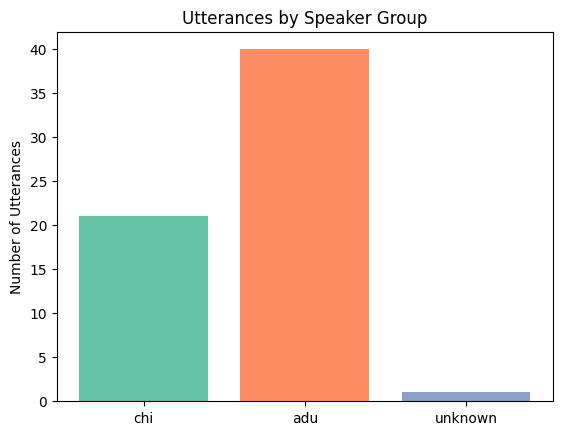

In [280]:
filepath = "/Users/Work/PycharmProjects/embeddings/Mandarin/Chang2/Anecdote/05.cha"  # replace with actual file name
counts = count_utterances_in_file(filepath)
plot_counts(counts)


G09_1.cha: {'adu': 93, 'chi': 44}
G12_2.cha: {'adu': 197, 'chi': 41}
G10_1.cha: {'adu': 135, 'chi': 54}
G12_3.cha: {'adu': 163, 'chi': 59}
G09_2.cha: {'chi': 50, 'adu': 141}
G12_1.cha: {'adu': 138, 'chi': 30}
G10_3.cha: {'adu': 28, 'chi': 18}
G10_2.cha: {'chi': 36, 'adu': 65}
G09_3.cha: {'chi': 25, 'adu': 52}
G14_2.cha: {'adu': 79, 'chi': 145}
G14_3.cha: {'chi': 122, 'adu': 53}
G14_1.cha: {'adu': 110, 'chi': 65}
G11_3.cha: {'chi': 55, 'adu': 116}
G13_1.cha: {'adu': 33}
G11_2.cha: {'adu': 205, 'chi': 98}
G13_2.cha: {'adu': 101}
G13_3.cha: {'adu': 40, 'chi': 4}
G11_1.cha: {'adu': 181, 'chi': 50}
G15_1.cha: {'chi': 142, 'adu': 215}
G15_2.cha: {'adu': 242, 'chi': 74}
G15_3.cha: {'chi': 48, 'adu': 124}
G04_1.cha: {'adu': 163, 'chi': 61}
G04_3.cha: {'adu': 229, 'chi': 45}
G04_2.cha: {'adu': 114, 'chi': 59}
G03_3.cha: {'adu': 291, 'chi': 54}
G03_2.cha: {'chi': 65, 'adu': 110}
G03_1.cha: {'adu': 112, 'chi': 50}
F13_2.cha: {'adu': 158, 'chi': 31}
F13_3.cha: {'adu': 124, 'chi': 8}
F13_1.cha: {'a

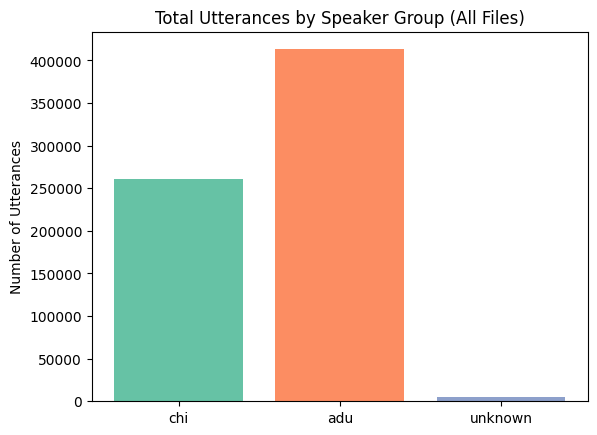

In [281]:
from collections import Counter
import matplotlib.pyplot as plt
import os

def plot_total_utterances_from_folder(folder_path):
    total_counts = Counter()
    file_count = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".cha"):
                filepath = os.path.join(root, filename)
                counts = count_utterances_in_file(filepath)
                print(f"{filename}: {dict(counts)}")
                total_counts.update(counts)
                file_count += 1

    print(f"\nProcessed {file_count} files.")
    print(f"Total counts: {dict(total_counts)}")

    labels = ["chi", "adu", "unknown"]
    values = [total_counts.get(label, 0) for label in labels]

    plt.bar(labels, values, color=["#66c2a5", "#fc8d62", "#8da0cb"])
    plt.ylabel("Number of Utterances")
    plt.title("Total Utterances by Speaker Group (All Files)")
    plt.show()

# Run it
plot_total_utterances_from_folder("Mandarin")


In [293]:
from collections import Counter
import matplotlib.pyplot as plt
import os

def plot_total_utterances_from_folder(folder_path):
    total_counts = Counter()
    file_count = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".cha"):
                filepath = os.path.join(root, filename)
                participant_info = create_participant_dict(filepath)

                code_to_group = {}
                for code, age in participant_info["chi"]:
                    if age is not None:
                        code_to_group[code] = "chi_with_age"
                    else:
                        code_to_group[code] = "chi_without_age"
                for code, _ in participant_info["adu"]:
                    code_to_group[code] = "adu"
                for code, _ in participant_info["unknown"]:
                    code_to_group[code] = "unknown"

                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        if line.startswith("*"):
                            speaker_code = line[1:4]
                            group = code_to_group.get(speaker_code, "unknown")
                            total_counts[group] += 1

                file_count += 1

    print(f"\nProcessed {file_count} files.")
    print(f"Total counts: {dict(total_counts)}")

    labels = ["chi_with_age", "chi_without_age", "adu", "unknown"]
    values = [total_counts.get(label, 0) for label in labels]

    plt.bar(labels, values, color=["#66c2a5", "#ffd92f", "#fc8d62", "#8da0cb"])
    plt.ylabel("Number of Utterances")
    plt.title("Total Utterances by Speaker Group (All Files)")
    plt.show()



Processed 3752 files.
Total counts: {'adu': 413087, 'chi_with_age': 258986, 'unknown': 5263, 'chi_without_age': 1460}


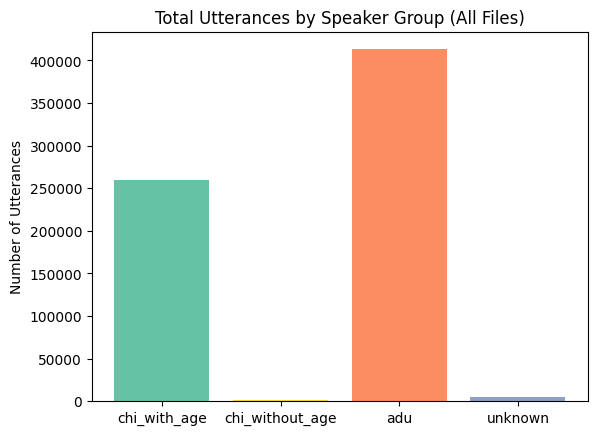

In [294]:
plot_total_utterances_from_folder("Mandarin")


In [296]:
from collections import Counter
import matplotlib.pyplot as plt
import os

def plot_child_utterances_by_age(folder_path):
    age_counts = Counter()
    file_count = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".cha"):
                filepath = os.path.join(root, filename)
                participant_info = create_participant_dict(filepath)

                code_to_age = {code: age for code, age in participant_info["chi"] if age is not None}

                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        if line.startswith("*"):
                            speaker_code = line[1:4]
                            if speaker_code in code_to_age:
                                age = code_to_age[speaker_code]
                                age_counts[age] += 1

                file_count += 1

    print(f"\nProcessed {file_count} files.")
    print(f"Age counts: {dict(age_counts)}")

    # Sort by age
    sorted_ages = sorted(age_counts.keys())
    values = [age_counts[age] for age in sorted_ages]

    plt.bar([str(age) for age in sorted_ages], values, color="#66c2a5")
    plt.xlabel("Age (years)")
    plt.ylabel("Number of Utterances")
    plt.title("Child Utterances by Age (All Files)")
    plt.show()



Processed 3752 files.
Age counts: {4: 46173, 5: 55617, 6: 30055, 3: 48565, 2: 41472, 7: 6286, 8: 1918, 9: 1015, 10: 850, 1: 25901, 0: 1134}


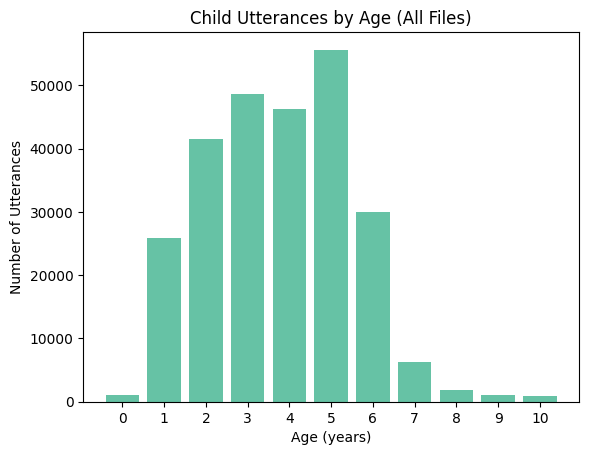

In [297]:
plot_child_utterances_by_age("Mandarin")


In [300]:
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import os
plt.rcParams['font.family'] = 'Arial Unicode MS'

def plot_ba_bei_by_age(folder_path):
    ba_counts = Counter()
    bei_counts = Counter()
    file_count = 0

    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.endswith(".cha"):
                filepath = os.path.join(root, filename)
                participant_info = create_participant_dict(filepath)
                code_to_age = {code: age for code, age in participant_info["chi"] if age is not None}

                with open(filepath, 'r', encoding='utf-8') as f:
                    for line in f:
                        if line.startswith("*"):
                            speaker_code = line[1:4]
                            if speaker_code in code_to_age:
                                age = code_to_age[speaker_code]
                                utterance = line[5:].strip()

                                if "把" in utterance:
                                    ba_counts[age] += 1
                                if "被" in utterance:
                                    bei_counts[age] += 1

                file_count += 1

    print(f"\nProcessed {file_count} files.")

    # All ages found
    all_ages = sorted(set(ba_counts.keys()) | set(bei_counts.keys()))
    ba_values = [ba_counts.get(age, 0) for age in all_ages]
    bei_values = [bei_counts.get(age, 0) for age in all_ages]

    x_labels = [str(age) for age in all_ages]
    x = range(len(x_labels))

    plt.bar(x, ba_values, width=0.4, label='把', align='center', color='#fc8d62')
    plt.bar([i + 0.4 for i in x], bei_values, width=0.4, label='被', align='center', color='#8da0cb')
    plt.xticks([i + 0.2 for i in x], x_labels)
    plt.xlabel("Age (years)")
    plt.ylabel("Number of Utterances")
    plt.title("Child Utterances Containing '把' and '被' by Age")
    plt.legend()
    plt.show()



Processed 3752 files.


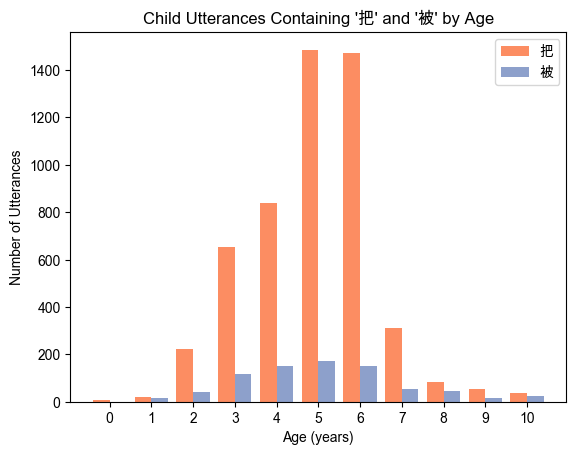

In [301]:
plot_ba_bei_by_age("Mandarin")
